# Simple Astrometry Solver from scratch

In [3]:
!date

Thu Feb  3 09:10:26 JST 2022


In [4]:
_sigma_coord_mas = 1. # 1mas

In [5]:
# ------------
# system package
#
import sys
import os
# ------------
# time package
#
import datetime, time
#
# ------------
# optmization package
#
from scipy.optimize import minimize
#import constrNMPy as cNM
#
# ------------
# MCMC package
#
import emcee, corner
## ------------
# basic package
#
#import numpy as np
import numpy
#from scipy import stats        
#from scipy.special import erf  
from scipy.interpolate import interp1d
#
# ------------
# time package
#
import datetime, time
#
# ------------
from matplotlib import pyplot
pyplot.rcParams['savefig.facecolor']='w'
pyplot.rcParams['ps.useafm'] = True
pyplot.rcParams['pdf.use14corefonts'] = True
pyplot.rcParams['text.usetex'] = True

# ------------
# astronomical package (astropy)
#
from astropy import table
from astropy.table import Table 
from astropy.table import Column
from astropy.io import fits

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.coordinates as coord
import astropy.units as u
#
# ------------
# astronomical package (PyGaia)
#
#from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
#from pygaia.astrometry.vectorastrometry import cartesianToSpherical, astrometryToPhaseSpace, phaseSpaceToAstrometry
#from pygaia.errors.astrometric import properMotionErrorSkyAvg, properMotionMinError, properMotionMaxError
#from pygaia.photometry.utils import vminiFromSpt, vabsFromSpt
#from pygaia.photometry.transformations import gminvFromVmini
# ------------
# astronomical package (Kohei Hattori) -- not cleaned yet.
#
#from useful_functions import *
#
# ------------
# astronomical package (agama)
#
#import agama
#_k = 4.74047
#Gyr_per_unit_time = 0.977793 # one unit time = 0.977793 Gyr
#agama.setUnits( mass=1., length=1, velocity=1)
#




In [6]:

#------
# sun
#
_xGC_sun_kpc =  -8.178 #8.
_yGC_sun_kpc =   0.
_zGC_sun_kpc =   0.
_vxGC_sun    =  11.1
_vyGC_sun    = 247.30  #220.
_vzGC_sun    =   7.25
G_Msun_kpcm1 = 4.30092e-06

#------
# Galactocentric coordinate syystem
#
from astropy.coordinates import SphericalCosLatDifferential
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

v_sun = [_vxGC_sun, _vyGC_sun, _vzGC_sun] * (u.km / u.s)  # [vx, vy, vz]
gc_frame = coord.Galactocentric(
    galcen_distance=numpy.fabs(_xGC_sun_kpc)*u.kpc,
    galcen_v_sun=v_sun,
    z_sun=0*u.pc)

#representation_type=CartesianRepresentation,##
#differential_type=SphericalCosLatDifferential)##




In [7]:
list_astropy_frame = \
['altaz', 'barycentricmeanecliptic', 'barycentrictrueecliptic', 'cirs', 'custombarycentricecliptic', 'fk4', 'fk4noeterms', 'fk5', 'galactic', 'galacticlsr', 'galactocentric', 'gcrs', 'geocentricmeanecliptic', 'geocentrictrueecliptic', 'hcrs', 'heliocentriceclipticiau76', 'heliocentricmeanecliptic', 'heliocentrictrueecliptic', 'icrs', 'itrs', 'lsr', 'lsrd', 'lsrk', 'precessedgeocentric', 'supergalactic', 'teme']

In [8]:
# obs >> Galactocentric Cartesian
def get_6Dgalcen_from_astrometry(phi, theta, plx, pmphi, pmtheta, radial_velocity, frame='icrs'):
    
    assert frame in list_astropy_frame
    # icrs
    # galactic
    # heliocentrictrueecliptic
    
    if (frame=='icrs'):
        c = SkyCoord(phi *u.deg, 
                     theta*u.deg, 
                     (1./plx)*u.kpc, 
                     pm_ra_cosdec=pmphi   *u.mas/u.yr, 
                     pm_dec      =pmtheta *u.mas/u.yr, 
                     radial_velocity=radial_velocity*u.km/u.s,
                     frame=frame)
    elif (frame=='galactic'):
        c = SkyCoord(phi     *u.deg, 
                     theta   *u.deg, 
                     (1./plx)*u.kpc,
                     pm_l_cosb = pmphi   *u.mas/u.yr, 
                     pm_b      = pmtheta *u.mas/u.yr, 
                     radial_velocity = radial_velocity*u.km/u.s,
                     frame=frame)
    
    elif (frame=='heliocentrictrueecliptic'):
        c = SkyCoord(phi     *u.deg, 
                     theta   *u.deg, 
                     (1./plx)*u.kpc,
                     pm_lon_coslat = pmphi   *u.mas/u.yr, 
                     pm_lat        = pmtheta *u.mas/u.yr, 
                     radial_velocity = radial_velocity*u.km/u.s,
                     frame=frame)
    else:
        print('Neither of icrs / galactic / heliocentrictrueecliptic ')
        return None
    
    gc = c.transform_to(gc_frame)

    return gc

In [9]:
# Galactocentric cartesian >> obs
# obs >> Galactocentric Cartesian
def get_astrometry_from_6Dgalcen(gc, frame='icrs'):
    
    # x,y,z,v_x,v_y,v_z
    assert frame in list_astropy_frame #.append('gc_frame')
    """
    gc = coord.SkyCoord(x  =  x *u.kpc, 
                        y  =  y *u.kpc,
                        z  =  z *u.kpc, 
                        v_x=v_x *u.km/u.s, 
                        v_y=v_y *u.km/u.s, 
                        v_z=v_z *u.km/u.s, 
                        frame=gc_frame ) 
    """
    if (frame=='icrs'):
        c = gc.transform_to(coord.ICRS) 
    elif (frame=='galactic'):
        c = gc.transform_to(coord.Galactic)
    elif (frame=='heliocentrictrueecliptic'):
        c = gc.transform_to(coord.HeliocentricTrueEcliptic)
    else:
        print('Target coordinate is neither of icrs / galactic / heliocentrictrueecliptic ')
        return None
    
    return c

In [10]:
# Galactocentric Cartesian >> gc object
def get_gcframe_from_6Dgalcen(x,y,z,v_x,v_y,v_z):
    gc = coord.SkyCoord(x  =  x *u.kpc, 
                        y  =  y *u.kpc,
                        z  =  z *u.kpc, 
                        v_x=v_x *u.km/u.s, 
                        v_y=v_y *u.km/u.s, 
                        v_z=v_z *u.km/u.s, 
                        frame=gc_frame ) 
    
    return gc

## check motion of an object at rest at Galactic center (something like Sgr A*)

In [11]:
gc = get_gcframe_from_6Dgalcen(0.,0.,0, 0, 0, 0)

In [12]:
print(get_astrometry_from_6Dgalcen(gc, frame='icrs'))

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (266.4051, -28.936175, 8.178)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-3.16405121, -5.54219719, -11.1)>


In [13]:
print(get_astrometry_from_6Dgalcen(gc, frame='galactic'))

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    (5.32967851e-05, -8.20090121e-05, 8.178)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-6.3790438, -0.18700262, -11.1)>


In [14]:
print(get_astrometry_from_6Dgalcen(gc, frame='heliocentrictrueecliptic'))

<SkyCoord (HeliocentricTrueEcliptic: equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, kpc)
    (266.83574791, -5.53632285, 8.178)
 (pm_lon_coslat, pm_lat, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-3.02418089, -5.61974196, -11.1)>


## Astrometry of a bulge star

In [15]:
_x, _y, _z, _v_x, _v_y, _v_z = 0.05, 0.05, 0.05, 100, 200, 50 
gc_bulge = get_gcframe_from_6Dgalcen(_x, _y, _z, _v_x, _v_y, _v_z)


In [16]:
HelTrueEcl_coord_bulge = get_astrometry_from_6Dgalcen(gc_bulge, frame='heliocentrictrueecliptic')

In [17]:
print(HelTrueEcl_coord_bulge)

<SkyCoord (HeliocentricTrueEcliptic: equinox=J2000.000, obstime=J2000.000): (lon, lat, distance) in (deg, deg, kpc)
    (266.70752514, -5.06078126, 8.22830383)
 (pm_lon_coslat, pm_lat, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-1.55019211, -0.52170765, 88.86906885)>


In [18]:
print('HeliocentricTrueEcliptic')
print('lon  ', HelTrueEcl_coord_bulge.lon / u.deg)
print('lat  ', HelTrueEcl_coord_bulge.lat / u.deg)
print('dist ', HelTrueEcl_coord_bulge.distance / u.kpc)
print('pmlon', HelTrueEcl_coord_bulge.pm_lon_coslat / (u.mas/u.yr))
print('pmlat', HelTrueEcl_coord_bulge.pm_lat  / (u.mas/u.yr))
print('HRV  ', HelTrueEcl_coord_bulge.radial_velocity / (u.km / u.s))

HeliocentricTrueEcliptic
lon   266.7075251446382
lat   -5.060781261106182
dist  8.228303834919267
pmlon -1.5501921132369663
pmlat -0.5217076453629648
HRV   88.86906884665565


## Motion of the bulge star

In [19]:
list_time   = numpy.linspace(-1.5,1.5,8001) * u.yr            ## year
list_LonSun = 2.*numpy.pi * (list_time/u.yr) * u.radian ## radian

In [20]:
print(list_time)

[-1.5      -1.499625 -1.49925  ...  1.49925   1.499625  1.5     ] yr


In [25]:
print(list_LonSun)

[-12.56637061 -12.50353876 -12.44070691 -12.37787506 -12.3150432
 -12.25221135 -12.1893795  -12.12654764 -12.06371579 -12.00088394
 -11.93805208 -11.87522023 -11.81238838 -11.74955652 -11.68672467
 -11.62389282 -11.56106097 -11.49822911 -11.43539726 -11.37256541
 -11.30973355 -11.2469017  -11.18406985 -11.12123799 -11.05840614
 -10.99557429 -10.93274243 -10.86991058 -10.80707873 -10.74424688
 -10.68141502 -10.61858317 -10.55575132 -10.49291946 -10.43008761
 -10.36725576 -10.3044239  -10.24159205 -10.1787602  -10.11592834
 -10.05309649  -9.99026464  -9.92743279  -9.86460093  -9.80176908
  -9.73893723  -9.67610537  -9.61327352  -9.55044167  -9.48760981
  -9.42477796  -9.36194611  -9.29911425  -9.2362824   -9.17345055
  -9.1106187   -9.04778684  -8.98495499  -8.92212314  -8.85929128
  -8.79645943  -8.73362758  -8.67079572  -8.60796387  -8.54513202
  -8.48230016  -8.41946831  -8.35663646  -8.29380461  -8.23097275
  -8.1681409   -8.10530905  -8.04247719  -7.97964534  -7.91681349
  -7.853981

In [21]:
list_HTE_lon = \
             HelTrueEcl_coord_bulge.lon + \
             HelTrueEcl_coord_bulge.pm_lon_coslat * list_time + \
(u.mas*u.kpc/HelTrueEcl_coord_bulge.distance) \
* numpy.sin(list_LonSun - HelTrueEcl_coord_bulge.lon)

list_HTE_lat = \
             HelTrueEcl_coord_bulge.lat + \
             HelTrueEcl_coord_bulge.pm_lat * list_time - \
(u.mas*u.kpc/HelTrueEcl_coord_bulge.distance) \
* numpy.cos(list_LonSun - HelTrueEcl_coord_bulge.lon) \
* numpy.sin(              HelTrueEcl_coord_bulge.lat) 




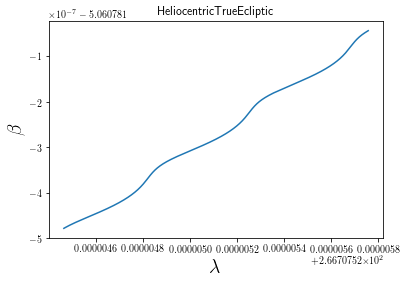

In [22]:
pyplot.plot(list_HTE_lon/u.deg, list_HTE_lat/u.deg)
pyplot.xlabel(r'$\lambda$', fontsize=20)
pyplot.ylabel(r'$\beta$',   fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')
pyplot.show()

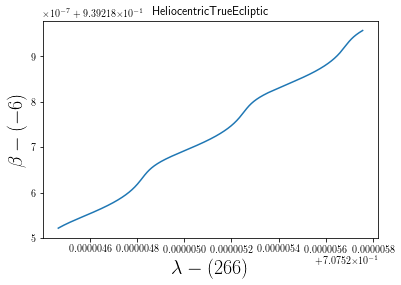

In [23]:
integer_lon = numpy.min(numpy.floor(list_HTE_lon/u.deg))
integer_lat = numpy.min(numpy.floor(list_HTE_lat/u.deg))

pyplot.plot(list_HTE_lon/u.deg - integer_lon, 
            list_HTE_lat/u.deg - integer_lat)
pyplot.xlabel(r'$\lambda - (%d)$' % (integer_lon), fontsize=20)
pyplot.ylabel(r'$\beta   - (%d)$' % (integer_lat), fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')

pyplot.show()



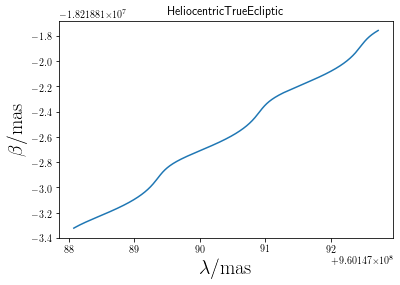

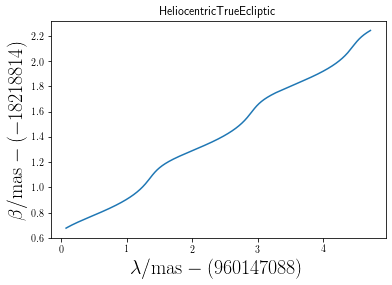

In [25]:
#integer_lon = numpy.min(numpy.floor(list_HTE_lon/u.mas))
#integer_lat = numpy.min(numpy.floor(list_HTE_lat/u.mas))

pyplot.plot(list_HTE_lon/(u.deg/3600/1000), 
            list_HTE_lat/(u.deg/3600/1000))
pyplot.xlabel(r'$\lambda/\mathrm{mas}$', fontsize=20)
pyplot.ylabel(r'$\beta  /\mathrm{mas}$', fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')

pyplot.show()


integer_lon = numpy.min(numpy.floor(list_HTE_lon/(u.deg/3600/1000)))
integer_lat = numpy.min(numpy.floor(list_HTE_lat/(u.deg/3600/1000)))

pyplot.plot(list_HTE_lon/(u.deg/3600/1000) - integer_lon, 
            list_HTE_lat/(u.deg/3600/1000) - integer_lat)
pyplot.xlabel(r'$\lambda/\mathrm{mas} - (%d)$' % (integer_lon), fontsize=20)
pyplot.ylabel(r'$\beta  /\mathrm{mas} - (%d)$' % (integer_lat), fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')

pyplot.show()




In [26]:

# save 
data_  = [ list_time, list_HTE_lon, list_HTE_lat ]
names_ = ('t', 'lambda_true', 'beta_true')

dtype_ = ( 'f8', 'f8', 'f8' )

table1 = Table(data_, 
               names=names_, 
               dtype=dtype_)

#table1.write('table1.fits', overwrite=True)



In [27]:
table1

t,lambda_true,beta_true
yr,deg,deg
float64,float64,float64
-1.5,266.7075257568485,-5.060781043556965
-1.499625,266.7075257566917,-5.060781043604305
-1.49925,266.70752575653506,-5.060781043651645
-1.498875,266.70752575637863,-5.060781043698988
-1.4985,266.70752575622237,-5.0607810437463305
-1.498125,266.70752575606633,-5.060781043793675
-1.49775,266.7075257559104,-5.06078104384102
-1.497375,266.7075257557547,-5.060781043888367


In [28]:


_sigma_coord = _sigma_coord_mas/3600./1000.*u.deg


numpy.random.seed(123)
table1['lambda'] = table1['lambda_true'] + _sigma_coord*numpy.random.randn(len(list_HTE_lon))
table1['beta']   = table1['beta_true']   + _sigma_coord*numpy.random.randn(len(list_HTE_lon))
table1['lambda_error'] = _sigma_coord*numpy.ones(len(list_HTE_lon))
table1['beta_error']   = _sigma_coord*numpy.ones(len(list_HTE_lon))


table1.write('table1_sigma_coord_%d_uas.fits' % (int(_sigma_coord_mas*1000)), overwrite=True)



In [29]:
table1

t,lambda_true,beta_true,lambda,beta,lambda_error,beta_error
yr,deg,deg,deg,deg,deg,deg
float64,float64,float64,float64,float64,float64,float64
-1.5,266.7075257568485,-5.060781043556965,266.70752545528444,-5.060780904345799,2.7777777777777776e-07,2.7777777777777776e-07
-1.499625,266.7075257566917,-5.060781043604305,266.7075260337321,-5.060781005845457,2.7777777777777776e-07,2.7777777777777776e-07
-1.49925,266.70752575653506,-5.060781043651645,266.7075258351402,-5.060780933370076,2.7777777777777776e-07,2.7777777777777776e-07
-1.498875,266.70752575637863,-5.060781043698988,266.70752533796343,-5.06078111786198,2.7777777777777776e-07,2.7777777777777776e-07
-1.4985,266.70752575622237,-5.0607810437463305,266.7075255955001,-5.060780770681373,2.7777777777777776e-07,2.7777777777777776e-07
-1.498125,266.70752575606633,-5.060781043793675,266.7075262147987,-5.060780560396442,2.7777777777777776e-07,2.7777777777777776e-07
-1.49775,266.7075257559104,-5.06078104384102,266.70752508183284,-5.060781478354822,2.7777777777777776e-07,2.7777777777777776e-07
-1.497375,266.7075257557547,-5.060781043888367,266.70752563661233,-5.060781121596636,2.7777777777777776e-07,2.7777777777777776e-07


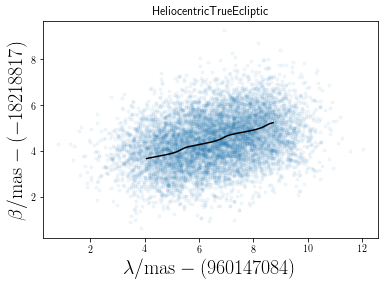

In [33]:

integer_lon = numpy.min(numpy.floor(table1['lambda']/(u.deg/3600/1000)))
integer_lat = numpy.min(numpy.floor(table1['beta'  ]/(u.deg/3600/1000)))


pyplot.plot(table1['lambda']/(u.deg/3600/1000) - integer_lon, 
            table1['beta'  ]/(u.deg/3600/1000) - integer_lat, '.', alpha=0.05)
#pyplot.plot(table1['lambda']/(u.deg/3600/1000) - integer_lon, 
#            table1['beta'  ]/(u.deg/3600/1000) - integer_lat, 'k-')

pyplot.plot(table1['lambda_true']/(u.deg/3600/1000) - integer_lon, 
            table1['beta_true'  ]/(u.deg/3600/1000) - integer_lat, 'k-')

pyplot.xlabel(r'$\lambda/\mathrm{mas} - (%d)$' % (integer_lon), fontsize=20)
pyplot.ylabel(r'$\beta  /\mathrm{mas} - (%d)$' % (integer_lat), fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')

#pyplot.savefig('fig_datasigma_coord_%d_uas')
pyplot.show()



In [34]:
!ls -l

total 5816
-rw-r--r--  1 kohei  staff   96359 Feb  2 22:05 1_make_mock_data-Copy1.ipynb
-rw-r--r--  1 kohei  staff  506755 Feb  3 06:57 1_make_mock_data-Copy2.ipynb
-rw-r--r--  1 kohei  staff  663763 Feb  3 08:57 1_make_mock_data-Copy3.ipynb
-rw-r--r--  1 kohei  staff  663763 Feb  3 09:10 1_make_mock_data-Copy4.ipynb
-rw-r--r--  1 kohei  staff  506322 Feb  2 23:05 1_make_mock_data.ipynb
-rw-r--r--  1 kohei  staff    8640 Feb  2 22:29 table1.fits
-rw-r--r--  1 kohei  staff    8640 Feb  2 23:15 table1_sigma_coord.fits
-rw-r--r--  1 kohei  staff  455040 Feb  3 09:11 table1_sigma_coord_1000_uas.fits
-rw-r--r--  1 kohei  staff   28800 Feb  3 07:53 table1_sigma_coord_125_uas.fits
-rw-r--r--  1 kohei  staff    8640 Feb  2 23:17 table1_sigma_coord_25_uas.fits


# Fit data

In [35]:
def model(lon, lat, plx, pm_lon_coslat, pm_lat):
    
    data_time   = table1['t'] ## yr
    data_LonSun = 2.*numpy.pi * (data_time/u.yr) * u.radian ## radian
    
    #gc = get_6Dgalcen_from_astrometry(lon, lat, plx, pm_lon_coslat, pm_lat, HRV, frame='heliocentrictrueecliptic')
    
    model_HTE_lon = \
               lon*u.deg \
             + pm_lon_coslat*(u.mas/u.yr) * data_time \
             + plx*u.mas \
             * numpy.sin(data_LonSun - lon*u.deg)

    model_HTE_lat = \
               lat*u.deg \
             + pm_lat*(u.mas/u.yr) * data_time \
             - plx*u.mas \
             * numpy.cos(data_LonSun - lon*u.deg) \
             * numpy.sin(              lat*u.deg) 

    return model_HTE_lon, model_HTE_lat




In [36]:
def log_prior(theta):
    lon, lat, plx, pm_lon_coslat, pm_lat = theta
    if (250 < lon < 280) * (-90 < lat < 90) :
        return 0.0
    return -numpy.inf

In [37]:
def log_likelihood(theta):
    lon, lat, plx, pm_lon_coslat, pm_lat = theta
    model_HTE_lon, model_HTE_lat = model(lon, lat, plx, pm_lon_coslat, pm_lat)
    sigma2 = (table1['lambda_error']/u.deg) ** 2 
    
    lnL_lon = -0.5 * numpy.sum((table1['lambda']/u.deg - model_HTE_lon/u.deg) ** 2 / sigma2 + numpy.log(sigma2))
    lnL_lat = -0.5 * numpy.sum((table1['beta'  ]/u.deg - model_HTE_lat/u.deg) ** 2 / sigma2 + numpy.log(sigma2))
    
    
    return lnL_lon+lnL_lat

In [38]:
def log_probability(theta):
    lp = log_prior(theta)
    if not numpy.isfinite(lp):
        return -numpy.inf
    return lp + log_likelihood(theta)

In [39]:
theta=\
numpy.array([\
HelTrueEcl_coord_bulge.lon / u.deg, 
HelTrueEcl_coord_bulge.lat / u.deg, 
1./(HelTrueEcl_coord_bulge.distance    / u.kpc), 
HelTrueEcl_coord_bulge.pm_lon_coslat   / (u.mas/u.yr), 
HelTrueEcl_coord_bulge.pm_lat          / (u.mas/u.yr) ])

In [40]:
print(log_likelihood(theta), log_probability(theta))

233574.8701985289 233574.8701985289


In [43]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood(*args)
initial = numpy.array([266, -5, 0.1, -1, -1 ]) 
soln = minimize(nll, initial)

In [44]:
print(soln)

      fun: -232183.34670324015
 hess_inv: array([[ 9.27890548e-18, -2.24280676e-20,  1.81396595e-17,
         2.70269065e-20, -3.79923941e-16],
       [-2.24280690e-20,  9.64702691e-18, -1.36549352e-17,
         4.81765725e-17,  2.86393452e-16],
       [ 1.81396595e-17, -1.36549353e-17,  1.40989341e-10,
        -5.01327644e-17, -8.13439743e-10],
       [ 1.63919677e-20,  4.80523791e-17, -5.00673630e-17,
         5.73027611e-16,  3.93387307e-17],
       [-3.79923940e-16,  2.86393453e-16, -8.13439743e-10,
         3.58338563e-17,  6.38713033e-08]])
      jac: array([ 5.69251291e+07, -4.60308302e+06,  1.33007812e+01,  4.08685938e+03,
       -5.05996094e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 641
      nit: 17
     njev: 105
   status: 2
  success: False
        x: array([ 2.66707525e+02, -5.06078126e+00,  1.43185564e-01, -8.71669793e-01,
       -5.37603035e-01])


In [45]:
for k in range(5):
    print(soln.x[k], theta[k])


266.7075251404368 266.7075251446382
-5.06078126311954 -5.060781261106182
0.14318556380912967 0.12153172999715946
-0.8716697925073389 -1.5501921132369663
-0.5376030348502163 -0.5217076453629648


In [46]:
import emcee

ndim = 5
nwalkers=20

pos = soln.x + 1e-4 * numpy.random.randn(nwalkers, ndim)  # Intentionally starting from [-4, 2]
#pos = theta + 1e-4 * numpy.random.randn(nwalkers, ndim)  # Intentionally starting from [-4, 2]


print('The initial locations of %d walkers' % (nwalkers))
print(pos)
#pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)  # Starting near the optimum solution
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability 
)
sampler.run_mcmc(pos, 5000);

The initial locations of 20 walkers
[[ 2.66707525e+02 -5.06070448e+00  1.42984200e-01 -8.71832014e-01
  -5.37699354e-01]
 [ 2.66707608e+02 -5.06082788e+00  1.43258363e-01 -8.71766801e-01
  -5.37555019e-01]
 [ 2.66707692e+02 -5.06084938e+00  1.43284203e-01 -8.71499513e-01
  -5.37637843e-01]
 [ 2.66707342e+02 -5.06075847e+00  1.43308247e-01 -8.71801707e-01
  -5.37645883e-01]
 [ 2.66707470e+02 -5.06058740e+00  1.43128853e-01 -8.71776348e-01
  -5.37601793e-01]
 [ 2.66707474e+02 -5.06073939e+00  1.43170832e-01 -8.71920464e-01
  -5.37343509e-01]
 [ 2.66707648e+02 -5.06075968e+00  1.43278457e-01 -8.71757643e-01
  -5.37556300e-01]
 [ 2.66707491e+02 -5.06079178e+00  1.43336964e-01 -8.71713882e-01
  -5.37465593e-01]
 [ 2.66707690e+02 -5.06094480e+00  1.43072173e-01 -8.71533427e-01
  -5.37825224e-01]
 [ 2.66707414e+02 -5.06065748e+00  1.43188256e-01 -8.71583793e-01
  -5.37804116e-01]
 [ 2.66707365e+02 -5.06087430e+00  1.43244272e-01 -8.71585833e-01
  -5.37626300e-01]
 [ 2.66707567e+02 -5.06078377

In [47]:
sampler


In [ ]:
fig, axes = pyplot.subplots(ndim+1, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#samples_ln_prob = sampler.get_log_prob()
#labels = ["m", "b", ]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], "k", alpha=0.3)
    ax.set_xlim(100, 5000)
    #ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

ax = axes[ndim]
ax.plot(sampler.lnprobability.T, "k", alpha=0.3)
ax.set_ylabel('log prob')

axes[-1].set_xlabel("step number");

In [ ]:
sampler.chain[0, 4990, :]

In [ ]:
for k in range(5):
    print(theta[k])

In [ ]:
if (True):
    burnin = 3800
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

    delta_coord = _sigma_coord/u.deg
    print('delta_coord in deg', delta_coord)
    fig = corner.corner(samples, labels=[r'$\lambda$/deg',r'$\beta$/deg',r'$\varpi$/(mas)',r'$\mu_\lambda$/(mas/yr)', r'$\mu_\beta$/(mas/yr)' ],
                        truths=theta, quantiles=[0.16, 0.5, 0.84],
                        range=[0.999,
                               0.999,
                               0.999,0.999,0.999],
                        label_kwargs={'fontsize': 21},
                        plot_datapoints=False,
                        show_titles=True,
                        title_args={'fontsize': 8},
                        title_fmt='.4f',)
    
    sigma_lambda   = 0.5*(numpy.percentile(samples[:,0],84)-numpy.percentile(samples[:,0],16))
    sigma_beta     = 0.5*(numpy.percentile(samples[:,1],84)-numpy.percentile(samples[:,1],16))
    sigma_pi       = 0.5*(numpy.percentile(samples[:,2],84)-numpy.percentile(samples[:,2],16))
    sigma_mulambda = 0.5*(numpy.percentile(samples[:,3],84)-numpy.percentile(samples[:,3],16))
    sigma_mubeta   = 0.5*(numpy.percentile(samples[:,4],84)-numpy.percentile(samples[:,4],16))




    
    pyplot.annotate(xy=(0.99,0.9), 
                    s=r'Number of data points: %d,  obs year span = %d yr' % (len(table1), 
                                                                              numpy.max(table1['t'])-numpy.min(table1['t'])), 
                    xycoords='figure fraction', ha='right', fontsize=20)
    pyplot.annotate(xy=(0.99,0.85), 
                    s=r'Data: sigma\_lambda = sigma\_beta = %lf mas' % (_sigma_coord_mas), 
                    xycoords='figure fraction', ha='right', fontsize=20)
    pyplot.annotate(xy=(0.99,0.80), 
                    s=r'MCMC: sigma\_lambda = %lf mas' % (sigma_lambda), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.75), 
                    s=r'MCMC: sigma\_beta = %lf mas' % (sigma_beta), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.70), 
                    s=r'MCMC: sigma\_pi = %lf mas' % (sigma_pi), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.65), 
                    s=r'MCMC: sigma\_mulambda = %lf mas/yr' % (sigma_mulambda), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.60), 
                    s=r'MCMC: sigma\_mubeta = %lf mas/yr' % (sigma_mubeta), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    

In [ ]:
if (True):
    burnin = 2500
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samples_new = numpy.array([(samples[:,0]-theta[0])*3600*1000,
                               (samples[:,1]-theta[1])*3600*1000,
                                samples[:,2],
                                samples[:,3],
                                samples[:,4]
                              ]).T

    delta_coord = _sigma_coord/u.deg
    print('delta_coord in deg', delta_coord)
    fig = corner.corner(samples_new, labels=[r'$(\lambda-\lambda_\mathrm{truth})$/mas',
                                             r'$(\beta-\beta_\mathrm{truth})$/mas',
                                             r'$\varpi$/(mas)',
                                             r'$\mu_\lambda$/(mas/yr)', 
                                             r'$\mu_\beta$/(mas/yr)' ],
                        truths=[0,0,theta[2],theta[3],theta[4]],
                        quantiles=[0.16, 0.5, 0.84],
                        range=[0.999,0.999,
                               0.999,0.999,0.999],
                        label_kwargs={'fontsize': 21},
                        plot_datapoints=False,
                        show_titles=True,
                        title_args={'fontsize': 8},
                        title_fmt='.4f',)
    
    sigma_lambda   = 0.5*(numpy.percentile(samples_new[:,0],84)-numpy.percentile(samples_new[:,0],16))
    sigma_beta     = 0.5*(numpy.percentile(samples_new[:,1],84)-numpy.percentile(samples_new[:,1],16))
    sigma_pi       = 0.5*(numpy.percentile(samples_new[:,2],84)-numpy.percentile(samples_new[:,2],16))
    sigma_mulambda = 0.5*(numpy.percentile(samples_new[:,3],84)-numpy.percentile(samples_new[:,3],16))
    sigma_mubeta   = 0.5*(numpy.percentile(samples_new[:,4],84)-numpy.percentile(samples_new[:,4],16))




    
    pyplot.annotate(xy=(0.99,0.9), 
                    s=r'Number of data points: %d,  obs year span = %d yr' % (len(table1), 
                                                                              numpy.max(table1['t'])-numpy.min(table1['t'])), 
                    xycoords='figure fraction', ha='right', fontsize=20)
    pyplot.annotate(xy=(0.99,0.85), 
                    s=r'Data: sigma\_lambda = sigma\_beta = %lf mas' % (_sigma_coord_mas), 
                    xycoords='figure fraction', ha='right', fontsize=20)
    pyplot.annotate(xy=(0.99,0.80), 
                    s=r'MCMC: sigma\_lambda = %lf mas' % (sigma_lambda), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.75), 
                    s=r'MCMC: sigma\_beta = %lf mas' % (sigma_beta), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.70), 
                    s=r'MCMC: sigma\_pi = %lf mas' % (sigma_pi), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.65), 
                    s=r'MCMC: sigma\_mulambda = %lf mas/yr' % (sigma_mulambda), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    pyplot.annotate(xy=(0.99,0.60), 
                    s=r'MCMC: sigma\_mubeta = %lf mas/yr' % (sigma_mubeta), 
                    xycoords='figure fraction', ha='right',  fontsize=20)
    

In [ ]:

integer_lon = numpy.min(numpy.floor(table1['lambda']/(u.deg/3600/1000)))
integer_lat = numpy.min(numpy.floor(table1['beta'  ]/(u.deg/3600/1000)))


pyplot.plot(table1['lambda']/(u.deg/3600/1000) - integer_lon, 
            table1['beta'  ]/(u.deg/3600/1000) - integer_lat, '.', alpha=0.1)
#pyplot.plot(table1['lambda']/(u.deg/3600/1000) - integer_lon, 
#            table1['beta'  ]/(u.deg/3600/1000) - integer_lat, 'k-')

inds = numpy.random.randint(len(samples), size=20)
for ind in inds:
    sample = samples[ind]
    model_lon, model_lat = model(*sample)
    
    pyplot.plot(model_lon/(u.deg/3600/1000)-integer_lon, 
                model_lat/(u.deg/3600/1000)-integer_lat, "C1", ls='-', alpha=1)


pyplot.plot(table1['lambda_true']/(u.deg/3600/1000) - integer_lon, 
            table1['beta_true'  ]/(u.deg/3600/1000) - integer_lat, 'k-')

pyplot.xlabel(r'$\lambda/\mathrm{mas} - (%d)$' % (integer_lon), fontsize=20)
pyplot.ylabel(r'$\beta  /\mathrm{mas} - (%d)$' % (integer_lat), fontsize=20)
pyplot.title('HeliocentricTrueEcliptic')


#pyplot.savefig('fig_datasigma_coord_%d_uas')
pyplot.show()




In [97]:
_sigma_coord_mas

0.125

In [213]:
"""
print('HeliocentricTrueEcliptic')
print('lon  ', HelTrueEcl_coord_bulge.lon / u.deg)
print('lat  ', HelTrueEcl_coord_bulge.lat / u.deg)
print('dist ', HelTrueEcl_coord_bulge.distance / u.kpc)
print('pmlon', HelTrueEcl_coord_bulge.pm_lon_coslat / (u.mas/u.yr))
print('pmlat', HelTrueEcl_coord_bulge.pm_lat  / (u.mas/u.yr))
print('HRV  ', HelTrueEcl_coord_bulge.radial_velocity / (u.km / u.s))
"""
model_HTE_lon, model_HTE_lat = \
model(HelTrueEcl_coord_bulge.lon / u.deg, 
      HelTrueEcl_coord_bulge.lat / u.deg, 
      1./(HelTrueEcl_coord_bulge.distance    / u.kpc), 
      HelTrueEcl_coord_bulge.pm_lon_coslat   / (u.mas/u.yr), 
      HelTrueEcl_coord_bulge.pm_lat          / (u.mas/u.yr) )

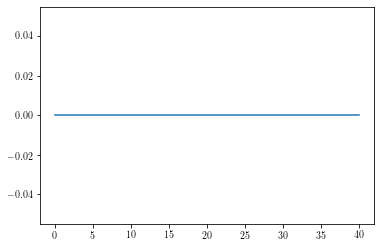

In [194]:
pyplot.plot(model_HTE_lon - table1['lambda_true'])


In [197]:
print('%.10lf' % (model_HTE_lon[0]/u.deg ))

266.7075260396


In [198]:
print('%.10lf' % (model_HTE_lon[10]/u.deg ))

266.7075256090


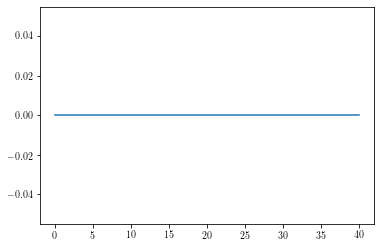

In [200]:
pyplot.plot(model_HTE_lat - table1['beta_true'])

In [210]:
for i in range(21):
    print('%.16lf' % (model_HTE_lat[i]/u.deg - table1['beta_true'][i]))

0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
0.0000000000000000
